In [2]:
%matplotlib widget
import os
import glob
import cuvis
import cuvis_ai
import warnings
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as T
from utils import generate_output_gif
warnings.filterwarnings('ignore')

C:\dev\cuvis.ai.examples\.venv\Lib\site-packages\cuvis\General.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Anomaly Detection in Hyperspectral Data

This notebook explores methods for detecting anomalies in hyperspectral image cubes. We will visualize results and demonstrate how different techniques highlight outliers or unusual spectral signatures. In particular, we aim to incorporate the RX detector — a classic algorithm for anomaly detection in hyperspectral imagery — to establish a strong baseline.

### Data: Lentils # we actually need to switch to that dataset

In this notebook, we will be using a CUVIS.AI session file (video file) which contains multiple sequential hyperspectral datacubes. We begin by loading the hyperspectral dataset that will be used to evaluate different anomaly detection methods. The RX detector will later operate on this data to identify pixels with statistically distinct spectral signatures.

To get started, we will download a dataset from Google Drive using Cuvis.AI

In [3]:
base_path = "../data/cuvis_ai_video"
if not os.path.exists(base_path):
    data_down = cuvis_ai.data.PublicDataSets()
    data_down.download_dataset("Aquarium", download_path=base_path)

In [4]:
# Let's look at a single example
cubes = glob.glob(f'{base_path}/*.cu3s')
data = cuvis.SessionFile(cubes[0]).get_measurement(0)
sample_cube = data.data.get('cube').array
waves = data.data.get('cube').wavelength
x,y,z = sample_cube.shape
print(f'Width: {x}, Height: {y}, Channels {z}')

Width: 275, Height: 290, Channels 51


As we can see, the dataset has 51 channels. We will be looking at the individual spectra to identify which of them could be considered statistical outliers

### RX Detector

The RX (Reed-Xiaoli) detector is a widely used method for hyperspectral anomaly detection. It computes how different a pixel's spectrum is from the background distribution by measuring the Mahalanobis distance from the global mean.

The RX anomaly score for a pixel **x** is given by:

$$
\text{RX}(\mathbf{x}) = (\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})
$$

Where:

- $\mathbf{x}$ is the spectral vector of the pixel,  
- $\boldsymbol{\mu}$ is the global mean spectrum,  
- $\boldsymbol{\Sigma}$ is the covariance matrix of the background,  
- $\boldsymbol{\Sigma}^{-1}$ is the inverse (or pseudo-inverse) covariance matrix.  

Pixels with higher RX scores are more likely to be anomalous.


In [5]:
# Define RX detector
rx = cuvis_ai.anomaly.RXDetector()

Now we will take the output of the RX detector and feed it into a decider node to threshold our decisions. Varying the threshold will determine what is considered an anomaly.

In [6]:
# Distance decider node
threshold = 150 # This threshold is set for the aquarium dataset! It will vary depending on the dataset.
decider = cuvis_ai.deciders.BinaryDecider(threshold)

Now that we have this simple, two-stage node, we connect them indicating the RX Detector will be the entry point for our data, which will then flow to the Binary Decider node to classify each pixel as anomalous or normal (0).

*This will throw an initialization warning "Unsatisfied dimensionality constraint", but this is expected behavior*

In [7]:
# Define and construct graph
graph = cuvis_ai.pipeline.Graph("DemoGraph")
graph.add_base_node(rx)
graph.add_edge(rx, decider)

Cuvis.AI has methods for handling large number of datacubes, including our session file which has over 200 images in it. We'll define it as a dataset to pass into the graph.

This dataset is *unlabeled*, meaning it only contains the raw hyperspectral datacubes, and not label files.

In [8]:
# Define unlabeled dataset
data = cuvis_ai.data.CuvisDataSet(base_path)

ERROR:root:Last function returned 'ok'.
NoneType: None


Reading from directory: ..\data\cuvis_ai_video
Found file: ..\data\cuvis_ai_video\Aquarium_Sample.cu3s
Session file has 251 cubes


### Evaluate Images

We can employ the RX detector in two ways. First, we can use it on a per-image basis, meaning that the image statistics are calculate on every image. This will only use the `forward` method. We will explore the other method later.

In [9]:
# Let's calculate statistics for just a single image
number_of_eval_images = 1
out = graph.forward(*data[0:number_of_eval_images])

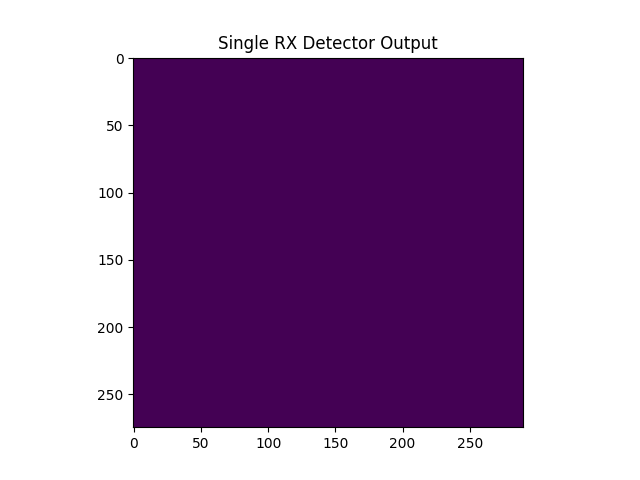

In [10]:
plt.figure()
plt.title('Single RX Detector Output')
plt.imshow(out[0])
plt.show()

### Visualize the Results

Now that we have defined a graph in cuvis.ai, we can use it to classify all the images in dataset. The cells below will generate and display showing the anomaly detector applied to the video rendered as a gif.

Generating frames: 100%|█████████████████████████████████████████████████████████████| 251/251 [02:31<00:00,  1.66it/s]


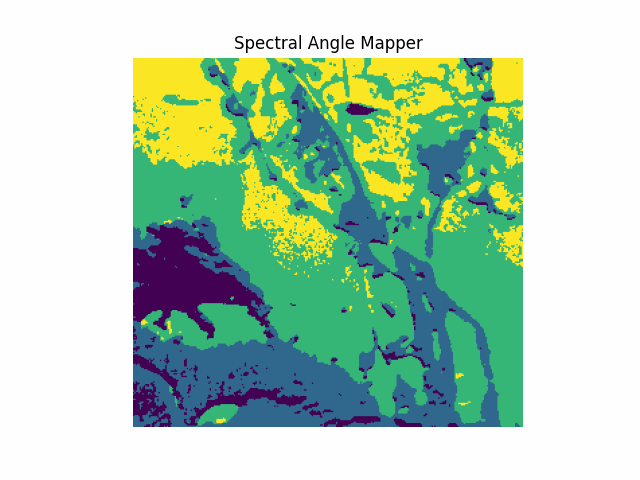

'../data/cuvis_ai_video\\rx_result.gif'

In [11]:
generate_output_gif(
    graph,
    data,
    base_path,
    gif_name="rx_result.gif",
    title="(Reed-Xiaoli) Anomaly Detector"
)

### Train an RX Model Using Statistics

Now that we've tested an RX detector using per-pixel image statistics, we will now demonstrate how we can use a build an anomaly classifier in a more "supervised" manner.

For instance, assume that we have a set of images which have no anomalies. We can use these normal images to build out the backend statistics (mean, $\boldsymbol{\mu}$ and covariance, $\boldsymbol{\Sigma}$) and then apply them to all other images in the dataset.

The interface we use to do this is nearly the same as using per-image statistics. In this case, we will call the `fit` method to mark that we want to calculate these summary statistics and train our anomaly detector.

In [ ]:
# Let's calculate statistics for just a single image
number_of_train_images = 2
out = graph.fit(*data[0:number_of_train_images])

After training, inference in performed the same way using the `forward` method. Execute the cell below to generate a new gif with the pre-trained RX detector, and see how the performance differs!

In [ ]:
generate_output_gif(
    graph,
    data,
    base_path,
    gif_name="rx_results_global.gif",
    title="(Reed-Xiaoli) Anomaly Detector, Global Statistics"
)